<a href="https://colab.research.google.com/github/wikiviggy/Chest-X-Ray-predictor/blob/master/chest_XRAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! git clone https://github.com/wikiviggy/Visiondataset.git

Cloning into 'Visiondataset'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (368/368), done.
remote: Compressing objects: 100% (368/368), done.
remote: Total 368 (delta 0), reused 368 (delta 0), pack-reused 0
Receiving objects: 100% (368/368), 61.87 MiB | 13.12 MiB/s, done.


In [4]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

  HTTP error 403 while getting http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
  Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl


In [0]:
import torchvision 
import torch.nn as nn
import torch.optim as optim 
from torchvision import datasets , models , transforms 
from torch.optim import lr_scheduler 
import numpy as np 
import matplotlib.pyplot as plt 
import time 
import os 
import copy 


In [0]:
# As VGG16 requires the data in certain form so ,we are transforming the data as per required(normalization)
train_datatransform = transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485 , 0.456 ,0.406] ,[0.229 , 0.224 , 0.225])])
test_datatrannsform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(), 
                                         transforms.Normalize([0.485 ,0.456 ,0.406] ,[0.229 , 0.224 ,0.225])])

In [0]:
#Yeah , we need to export the data that we have created 
train_image_dataset = datasets.ImageFolder(root='./Visiondataset/train',transform=train_datatransform )
test_image_dataset = datasets.ImageFolder(root ='./Visiondataset/test', transform=test_datatrannsform)

In [0]:
#DataLoader - Load the train and test data in the form of batches

train_dataloader = torch.utils.data.DataLoader(train_image_dataset , batch_size =4 ,shuffle=True , num_workers=4 )
test_dataloader = torch.utils.data.DataLoader(test_image_dataset , batch_size = 4 , shuffle= True , num_workers=4)

In [9]:
class_names = train_image_dataset.classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

['cardiomegaly', 'normal', 'opacity']
cuda:0


In [10]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


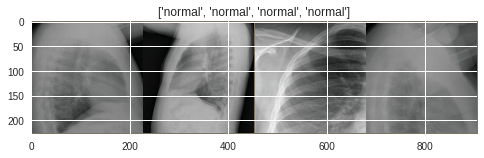

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [0]:
def train_model(model , criterion , optimizer , scheduler ,num_epochs):
  since =time.time()
  best_acc =0.0
  best_model_wts = copy.deepcopy(model.state_dict())
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch , num_epochs -1))
    print('-'*10)
    
    scheduler.step()
    model.train()
    
    running_loss = 0.0 
    running_corrects = 0
    
    for inputs , labels in train_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      
      outputs = model(inputs)
      _, preds = torch.max(outputs , 1)
      loss = criterion(outputs , labels)
      
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item() *inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      
    epoch_loss = running_loss / len(train_image_dataset)
    epoch_acc = running_corrects.double() / len(train_image_dataset)
    
    print('Loss : {}  Acc :{}'.format(epoch_loss , epoch_acc))
    
    if epoch_acc > best_acc:
      best_acc =epoch_acc 
      best_model_wts = copy.deepcopy(model.state_dict())
    
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    
    
  model.load_state_dict(best_model_wts)
  return model
  

In [0]:
def set_require_grad(model , feature_extract):
  if feature_extract:
    for param in model.parameters():
      param.require_grad=False

In [14]:
#VGG16
model_ft = models.vgg16_bn(pretrained =True)
set_require_grad(model_ft,False)
num_features = model_ft.classifier[6].in_features
features = list(model_ft.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
model_ft.classifier = nn.Sequential(*features)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters() , lr = 0.0015 , momentum =0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size =7 ,gamma=0.1)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
553507836it [00:06, 90516898.59it/s]


In [19]:
#DENSENET 121
model_dn  = models.densenet121(pretrained=True)
set_require_grad(model_dn,False)
features = list(model_dn.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(1024, len(class_names))]) # Add our layer with 4 outputs
model_dn.classifier = nn.Sequential(*features)

model_dn = model_dn.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_dn = optim.SGD(model_dn.parameters() , lr = 0.002 , momentum =0.95)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_dn,step_size = 7 ,gamma=0.1)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
#RESNET 50
model_res = models.resnet50(pretrained=True)
set_require_grad(model_res,False)
features = list(model_res.children())[:-1] # Remove last layer
features.extend([nn.Linear(2048, len(class_names))]) # Add our layer with 4 outputs
model_res.classifier = nn.Sequential(*features)

model_res = model_res.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_res = optim.SGD(model_res.parameters() , lr = 0.0016 , momentum =0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_dn,step_size = 7 ,gamma=0.1)

In [18]:
#VGG16
model_ft = train_model(model_ft , criterion , optimizer_ft , exp_lr_scheduler , num_epochs = 50)

Epoch 0/49
----------
Loss : 0.7022805255220597  Acc :0.7710843373493976
Epoch 1/49
----------
Loss : 0.6654110006898283  Acc :0.7801204819277109
Epoch 2/49
----------
Loss : 0.6798924166395004  Acc :0.7710843373493976
Epoch 3/49
----------
Loss : 0.6522412423986986  Acc :0.7680722891566265
Epoch 4/49
----------
Loss : 0.625839711312788  Acc :0.786144578313253
Epoch 5/49
----------
Loss : 0.6361937120736364  Acc :0.7650602409638555
Epoch 6/49
----------
Loss : 0.6581904119755848  Acc :0.783132530120482
Epoch 7/49
----------
Loss : 0.6043322799076517  Acc :0.7710843373493976
Epoch 8/49
----------
Loss : 0.5704970661416111  Acc :0.7801204819277109
Epoch 9/49
----------
Loss : 0.6049467842262911  Acc :0.7981927710843374
Epoch 10/49
----------
Loss : 0.6032993592411638  Acc :0.7680722891566265
Epoch 11/49
----------
Loss : 0.5363769669489689  Acc :0.7951807228915663
Epoch 12/49
----------
Loss : 0.5634318058749279  Acc :0.7981927710843374
Epoch 13/49
----------
Loss : 0.6028092352740736  A

In [23]:
#DENSENET
model_dn = train_model(model_dn , criterion , optimizer_dn , exp_lr_scheduler , num_epochs = 50)

Epoch 0/49
----------
Loss : 1.5194407423217613  Acc :0.6807228915662651
Epoch 1/49
----------
Loss : 1.0828321085995938  Acc :0.710843373493976
Epoch 2/49
----------
Loss : 0.9612957363028124  Acc :0.7560240963855422
Epoch 3/49
----------
Loss : 0.8552796822714518  Acc :0.7620481927710844
Epoch 4/49
----------
Loss : 0.8267226881650557  Acc :0.75
Epoch 5/49
----------
Loss : 0.8077029865908335  Acc :0.75
Epoch 6/49
----------
Loss : 0.8680067635085209  Acc :0.783132530120482
Epoch 7/49
----------
Loss : 0.6869455304849579  Acc :0.783132530120482
Epoch 8/49
----------
Loss : 0.6586856316012072  Acc :0.783132530120482
Epoch 9/49
----------
Loss : 0.6544868739613567  Acc :0.783132530120482
Epoch 10/49
----------
Loss : 0.6546841689262045  Acc :0.783132530120482
Epoch 11/49
----------
Loss : 0.65827195220683  Acc :0.786144578313253
Epoch 12/49
----------
Loss : 0.6192361184631485  Acc :0.7801204819277109
Epoch 13/49
----------
Loss : 0.6298069052667503  Acc :0.786144578313253
Epoch 14/49


In [25]:
#RESNET 50
model_res = train_model(model_res , criterion , optimizer_res , exp_lr_scheduler , num_epochs = 50)

Epoch 0/49
----------
Loss : 1.6723814082432942  Acc :0.713855421686747
Epoch 1/49
----------
Loss : 0.8040681732706276  Acc :0.7349397590361446
Epoch 2/49
----------
Loss : 0.7398511630943022  Acc :0.7771084337349398
Epoch 3/49
----------
Loss : 0.7361949452434677  Acc :0.7620481927710844
Epoch 4/49
----------
Loss : 0.7374646261513952  Acc :0.7680722891566265
Epoch 5/49
----------
Loss : 0.6730501910290086  Acc :0.7710843373493976
Epoch 6/49
----------
Loss : 0.6683200238698936  Acc :0.7710843373493976
Epoch 7/49
----------
Loss : 0.6621700956160763  Acc :0.783132530120482
Epoch 8/49
----------
Loss : 0.6728497930319912  Acc :0.7710843373493976
Epoch 9/49
----------
Loss : 0.6663573276565735  Acc :0.7740963855421688
Epoch 10/49
----------
Loss : 0.6635067620909357  Acc :0.7771084337349398
Epoch 11/49
----------
Loss : 0.7042907921664686  Acc :0.7740963855421688
Epoch 12/49
----------
Loss : 0.6523965726415795  Acc :0.7771084337349398
Epoch 13/49
----------
Loss : 0.6531881481768137  

In [0]:
def eval_model(model , criterion):
  
  model.eval()
  
  running_loss = 0.0 
  running_corrects = 0
  
  for inputs , labels in test_dataloader :
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs,1)
    loss = criterion(outputs , labels)
    
    running_loss += loss.item() *inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
  
        
  loss = running_loss / len(test_image_dataset)
  acc = running_corrects.double() / len(test_image_dataset)
    
  print('Loss : {}  Acc :{}'.format(loss , acc))
    
 

In [37]:
#VGG16 Test accuracy
eval_model(model_ft , criterion)

Loss : 1.616552369935172  Acc :0.5357142857142857


In [35]:
#DENSENET Test accuracy
eval_model(model_dn , criterion)

Loss : 1.2122576492173331  Acc :0.42857142857142855


In [34]:
#RESNET 50
eval_model(model_res , criterion)


Loss : 1.1128622463771276  Acc :0.5714285714285714


In [0]:
torch.save(model_res, 'model_resnet.h5')

In [0]:
torch.save(model_ft, 'model_vggnet.h5')

In [0]:
torch.save(model_dn,'model_densenet.h5')

In [0]:

model = torch.load('model_resnet.h5')

In [42]:

criterion = nn.CrossEntropyLoss()
eval_model(model , criterion)

Loss : 1.231881822858538  Acc :0.5357142857142857


Actual labels are: ['normal', 'normal', 'cardiomegaly', 'normal']
Predictions are: ['normal', 'normal', 'cardiomegaly', 'normal']


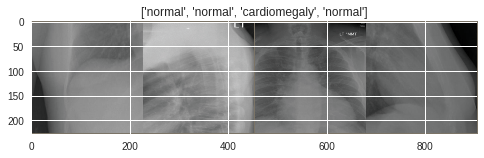

In [43]:
# Get a batch of training data
inputs, classes = next(iter(test_dataloader))
out = torchvision.utils.make_grid(inputs)
l = [class_names[x] for x in classes]
print("Actual labels are:" , l) #actual

inputs = inputs.to(device)
classes = classes.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs,1)
p = [class_names[x] for x in preds]

print("Predictions are:", p) #prediction
loss = criterion(outputs , classes)
imshow(out, title=l)

In [113]:
from PIL import Image
from torch.autograd import Variable

def predict_image(image):
    image_tensor = test_datatrannsform(image).float()
    image_tensor = Variable(image_tensor,requires_grad=True)
    image_tensor = image_tensor.unsqueeze(0)
    
    return image_tensor.cuda()
  

im = Image.open('/content/gdrive/My Drive/NIH/test/opacity/7.png')  #imagepath
to_pil = transforms.ToPILImage()
trans1 = transforms.ToTensor()

im1 = to_pil(trans1(im))


ans = predict_image(im1)

outp = model(ans)

_, preds = torch.max(outp,1)
p = [class_names[x] for x in preds]

print("Predicted label for given image is:", p) #prediction






Predicted label for given image is: ['cardiomegaly']
